In [1]:
from contextlib import contextmanager

import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns

from statsmodels.stats import proportion

In [2]:
def label_distplots(values, labels, kde=True, hist=True, bins=None):
    for label in labels.unique():
        sns.distplot(values[labels == label], kde=kde, hist=hist, label=f'Label = {label}', norm_hist=True, bins=bins)
    plt.legend();

In [3]:
def get_figsize():
    return plt.rcParams['figure.figsize']


def set_figsize(width, height):
    plt.rcParams['figure.figsize'] = width, height
    
    
@contextmanager
def change_figsize(width, height):
    new_size = (width, height)
    old_size = get_figsize()
    try:
        set_figsize(*new_size)
        yield
    finally:
        set_figsize(*old_size)

In [4]:
def get_bootstrap_samples(arr, n_samples):
    size = len(arr)
    indices = np.random.randint(0, size, (n_samples, size))
    return arr[indices]

In [5]:
df = pd.read_csv('credit_card_default_analysis.csv')
print(df.shape)
df.head()

(30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
df['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [7]:
# Для удобства работы заменим метки пола
# Мужской - 1, женский - 0
df['SEX'] = df['SEX'].map({1: 1, 2: 0})

In [8]:
df['default'].mean()

0.2212

In [9]:
df.isna().sum().sum()

0

In [10]:
good = df.loc[df['default'] == 0]
bad = df.loc[df['default'] == 1]
good.shape, bad.shape

((23364, 25), (6636, 25))

# Task 1

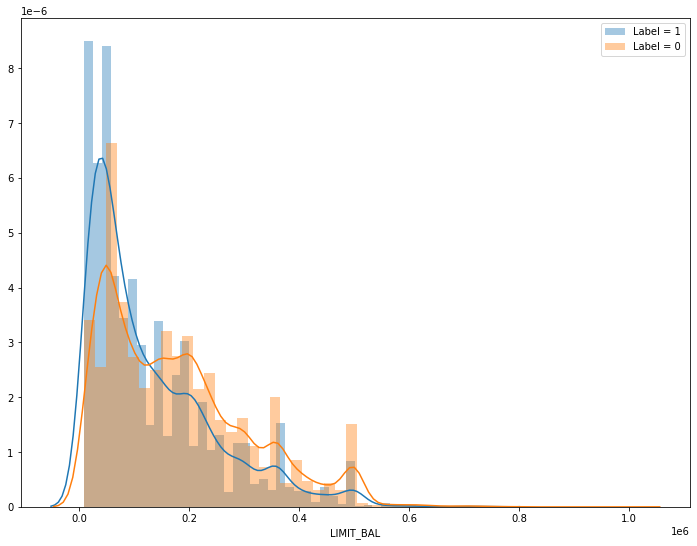

In [11]:
with change_figsize(12, 9):
    label_distplots(df['LIMIT_BAL'], df['default'])

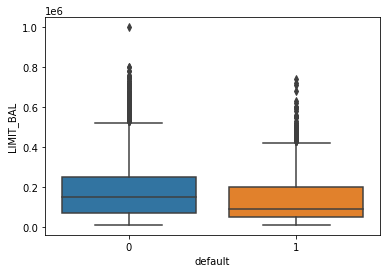

In [12]:
sns.boxplot(y='LIMIT_BAL', x='default', data=df)

In [13]:
good['LIMIT_BAL'].mean(), bad['LIMIT_BAL'].mean()

(178099.72607430234, 130109.65641952984)

In [14]:
good['LIMIT_BAL'].median(), bad['LIMIT_BAL'].median()

(150000.0, 90000.0)

## Subtask 1.1

In [15]:
sample_limit_good = get_bootstrap_samples(good['LIMIT_BAL'].values, 1000)
sample_limit_bad = get_bootstrap_samples(bad['LIMIT_BAL'].values, 1000)

In [16]:
medians_good = np.median(sample_limit_good, axis=1)
medians_bad = np.median(sample_limit_bad, axis=1)
medians_diff = medians_good - medians_bad
np.quantile(medians_diff, [0.025, 0.975])

array([60000., 70000.])

## Subtask 1.2

In [17]:
stats.mannwhitneyu(good['LIMIT_BAL'], bad['LIMIT_BAL'])

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

**Вывод:** Медианы в группах существенно отличаются - люди, вернувшие кредит, в среднем получали более высокий лимит.

# Task 2

In [48]:
good['SEX'].mean(), bad['SEX'].mean()

(0.38585002568053417, 0.43294153104279687)

Среди невернувших кредит доля мужчин выше

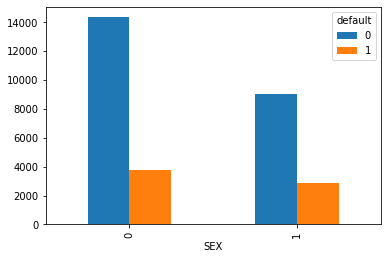

In [38]:
pd.crosstab(df['SEX'], df['default']).plot(kind='bar')

In [54]:
# Проверим доверительные интервалы
good_normal_confint = proportion.proportion_confint(
    good['SEX'].sum(),
    len(good),
    alpha=0.05, 
    method='normal',
)
bad_normal_confint = proportion.proportion_confint(
    bad['SEX'].sum(),
    len(bad),
    alpha=0.05, 
    method='normal',
)
good_normal_confint, bad_normal_confint

((0.37960806572767264, 0.3920919856333957),
 (0.4210202357094044, 0.44486282637618935))

Доверительные интервалы не пересекаются, значит различие стстистически значимо

In [56]:
# Проверим с использованием статистического критерия для долей
proportion.proportions_ztest(
    [good['SEX'].sum(), bad['SEX'].sum()], 
    [len(good), len(bad)]
)

(-6.921375088562897, 4.472804335814113e-12)

Тест также показывает значимое различие

# Task 3

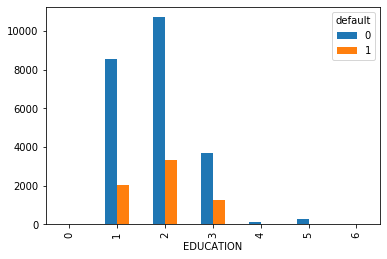

In [57]:
pd.crosstab(df['EDUCATION'], df['default']).plot(kind='bar')

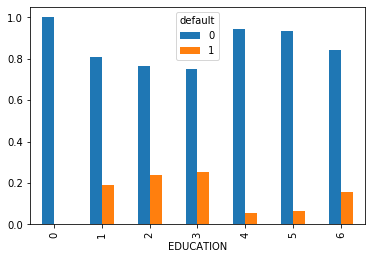

In [101]:
# Нормируем значения в таблице сопряженности на суммы по строкам
ct = pd.crosstab(df['EDUCATION'], df['default'])
normed = ct.values / ct.sum(axis=1).values[:, np.newaxis]
normed = pd.DataFrame(normed, columns=ct.columns, index=ct.index)
normed.plot(kind='bar')

In [75]:
ct = pd.crosstab(df['EDUCATION'], df['default'])
chi2, p_value, dof, expected = stats.chi2_contingency(ct)

In [76]:
p_value

1.2332626245415605e-32

Критерий Хи-квадрат показывает, что образование значимо влияет на возвращаемость долга

In [77]:
# Реальная таблица сопряженности
ct

default,0,1
EDUCATION,,
0,14,0
1,8549,2036
2,10700,3330
3,3680,1237
4,116,7
5,262,18
6,43,8


In [86]:
# Ожидаемая таблица сопряженности
expected = pd.DataFrame(
    expected, 
    columns=ct.columns, 
    index=ct.index,
)
expected.round(1)

default,0,1
EDUCATION,,
0,10.9,3.1
1,8243.6,2341.4
2,10926.6,3103.4
3,3829.4,1087.6
4,95.8,27.2
5,218.1,61.9
6,39.7,11.3


In [87]:
# Разность между реальными и ожидаемыми значениями
diff = ct - expected
diff.round(1)

default,0,1
EDUCATION,,
0,3.1,-3.1
1,305.4,-305.4
2,-226.6,226.6
3,-149.4,149.4
4,20.2,-20.2
5,43.9,-43.9
6,3.3,-3.3


In [88]:
# Поскольку в таблице с разностями 
# сумма в каждой строке и в каждом столбце = 0,
# то значения в каждой строке равны по модулю и противоположны по знаку.
# Будем исследовать столбец с невозвратом долга
diff = diff[1]
diff.round(1)

EDUCATION
0     -3.1
1   -305.4
2    226.6
3    149.4
4    -20.2
5    -43.9
6     -3.3
Name: 1, dtype: float64

In [92]:
# Чтобы оценить влияние уровня образования 
# отнесем значение разности к общему числу человек с таким уровнем образования
rel_diff = diff /  ct.sum(axis=1)
rel_diff.round(3)

EDUCATION
0   -0.221
1   -0.029
2    0.016
3    0.030
4   -0.164
5   -0.157
6   -0.064
dtype: float64

Здесь отрицательные числа говорят о том, что кредит вернуло больше людей,
чем ожидалось, а положительные - наоборот. Чем больше число по модулю,
тем сильнее разность.

Видно, что лучше себя показывают люди с очень высоким и очень низким образованием, а хуже - люди со средним, наиболее типичным образованием.

Можно предположить, что доктора наук действительно более ответственные. Однако их очень мало в выборке, чтобы делать выводы.

По поводу людей с низким уровнем образования можно предположить, что банк проверяет их более тщательно и потому уровень невозврата ниже.

# Task 4

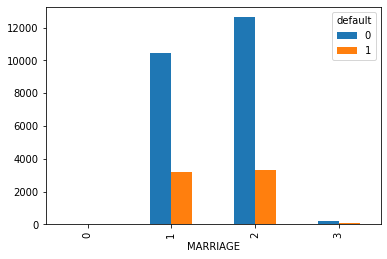

In [93]:
pd.crosstab(df['MARRIAGE'], df['default']).plot(kind='bar')

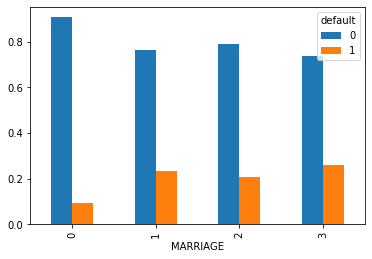

In [102]:
# Нормируем значения в таблице сопряженности на суммы по строкам
ct = pd.crosstab(df['MARRIAGE'], df['default'])
normed = ct.values / ct.sum(axis=1).values[:, np.newaxis]
normed = pd.DataFrame(normed, columns=ct.columns, index=ct.index)
normed.plot(kind='bar')

По графику видно, что холостые немного реже допускают просрочку.

Доля просрощек существенно меньше среди тех, кто отказался отвечать,, однако их доля настолько мала, что делать выводы нельзя.

In [103]:
chi2, p_value, dof, expected = stats.chi2_contingency(ct)

In [104]:
p_value

8.825862457577375e-08

Хи-квадрат говорит о том, что различия значимы.

# Task 5

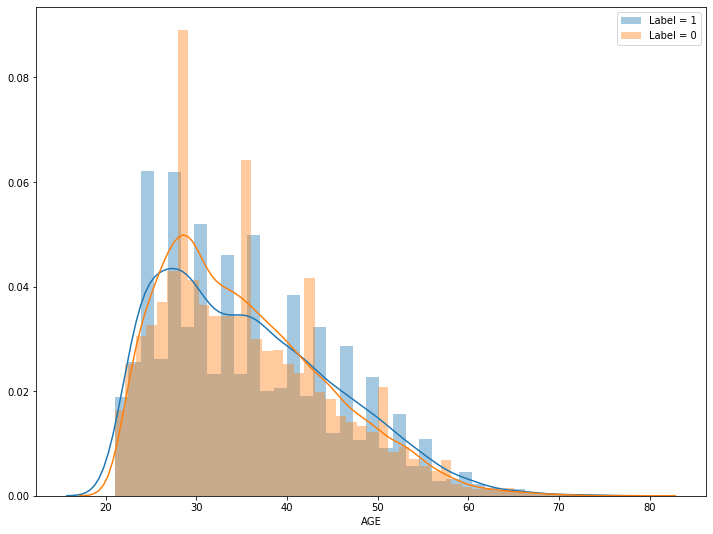

In [106]:
with change_figsize(12, 9):
    label_distplots(df['AGE'], df['default'])

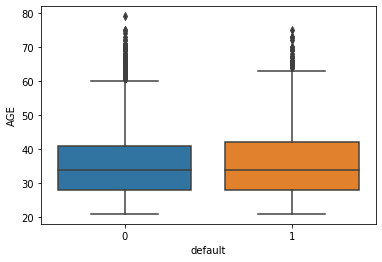

In [107]:
sns.boxplot(y='AGE', x='default', data=df)

Судя по графикам, различия в возрасте среди вернувших и не вернувших крайне малы.

In [109]:
good['AGE'].mean(), bad['AGE'].mean()

(35.417265879130284, 35.72573839662447)

In [108]:
good['AGE'].median(), bad['AGE'].median()

(34.0, 34.0)

## Subtask 5.1

In [110]:
sample_limit_good = get_bootstrap_samples(good['AGE'].values, 1000)
sample_limit_bad = get_bootstrap_samples(bad['AGE'].values, 1000)

In [111]:
medians_good = np.median(sample_limit_good, axis=1)
medians_bad = np.median(sample_limit_bad, axis=1)
medians_diff = medians_good - medians_bad
np.quantile(medians_diff, [0.025, 0.975])

array([-1.,  0.])

Доверительный интервал вклячает 0, значит мы не можем говорить о том, что различия значимы

## Subtask 5.2

In [112]:
stats.mannwhitneyu(good['AGE'], bad['AGE'])

MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)

Тест Манна-Уитни также не позволяет отвергнуть нулевую гипотезу о том, что значения возрастов взяты из одного распределения